In [3]:
import pyspark
from datetime import datetime
import re
import matplotlib.pyplot as plt
#from wordcloud import WordCloud, ImageColorGenerator
import numpy as np
from PIL import Image
#from langdetect import detect, detect_langs, DetectorFactory
import pandas as pd

from collections import OrderedDict
from bokeh.plotting import figure, output_file, show, output_notebook


**<font size=5> Introduction</font>**<br>
The objective of this notebook is to **<u>analyze tweets from Donald Trump since 2015</u>**. <br>
Several aspects are analysed: time pattern, sentiment analysis (positive/negative words), languages used<br>
 **<font color= green>Major findings</font>** from analysing the dataset are in bold green font hereafter <br>


In [4]:
sc = pyspark.SparkContext(appName="Spark RDD Introduction Exercises")

In [5]:
rdd_tweets = sc.textFile('trump_tweets_text_date.txt')

# cache this RDD since it's huge and will be used a lot
rdd_tweets.cache()

# print a sample of 4 lines of rdd_tweets
rdd_tweets.take(4)

['White House news conference today at 5:30 P.M. Eastern. Thank you!,04-15-2020 20:49:31',
 'We are having very productive calls with the leaders of every sector of the economy who are all-in on getting America back to work and soon. More to come! #MAGA,04-15-2020 19:02:47',
 'My condolences to the Steinbrenner family and the entire @Yankees Organization on the passing of Hank Steinbrenner. He was a friend and will be missed greatly by all! https://t.co/nHsO7Wy0oM,04-15-2020 15:48:05',
 '#ThanksForDelivering @UPS! https://t.co/4Sis7Tme17,04-15-2020 15:39:58']

# compute some basic KPIs

**<font color= green> count total number of tweets </font>**

In [6]:
N_tweets = rdd_tweets.count()
print("there are", N_tweets, "tweets")

there are 28972 tweets


**<font color= green> count number of retweets </font>**

In [7]:
N_retweet = rdd_tweets.filter(lambda x: x[0:2] == 'RT').count()
print("there are ", N_retweet, " retweets. This represents ", round(100*N_retweet/N_tweets,1), '% of all tweets')

there are  5771  retweets. This represents  19.9 % of all tweets


get all tweet dates

In [8]:
# dates are always the last 19 characters with format mm-dd-YYYY hh:mm:ss 
rdd_dates_str = rdd_tweets.map(lambda x : x[-19:])

**<font color= green> get the year and see the number of tweets every year </font>**

In [9]:
rdd_year = rdd_dates_str.map(lambda x : (x[6:10],1))\
                        .reduceByKey(lambda a,b: a+b)\
                        .sortBy(lambda tuple: tuple[0], ascending=True)

In [10]:
# display tweet count per year
for val in rdd_year.collect():
    print("There are", val[1], "tweets in", val[0])


There are 6 tweets in 2014
There are 7536 tweets in 2015
There are 4225 tweets in 2016
There are 2602 tweets in 2017
There are 3568 tweets in 2018
There are 7818 tweets in 2019
There are 3217 tweets in 2020


**<font color= green> we see that 2015 and 2019 get much more tweets. <br>
2014 is only 1 day  <br>
2020 is still on-going <br>
2015 Trump was not president so could tqeet out-of-control <br>
2019 is probably driven by the impeachment <br> </font>**


# plot tweet count per year per month

In [11]:
# get month and year, create tuple and count
rdd_month_year = rdd_dates_str.map(lambda x : ( (x[0:2] , x[6:10]) , 1))\
                        .reduceByKey(lambda a,b: a+b)\
                        .sortBy(lambda tuple: tuple[0], ascending=True)

In [12]:
# remove 2014 and 2020 since these are incomplete
rdd_month_year_filter=rdd_month_year.filter(lambda x: (x[0][1] in ['2015','2016','2017','2018','2019']))\
                    .sortBy(lambda tuple: tuple[0][1], ascending=True)

In [13]:
# format data to be "dataframe friendly" 
rdd_month_year_filter_list = rdd_month_year_filter.collect()
rdd_month_year_list = []
for value in rdd_month_year_filter_list:
    rdd_month_year_list.append(value[1])
rdd_month_year_list

data_np=np.reshape(np.asarray(rdd_month_year_list), (-1,12))


In [14]:
# manually put month in a list
months=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
# group are not relevant in our case, we just use it to get an uniform color for the all months that stands out
wedge_group=['A','A','A','A','A','A','A','A','A','A','A','A']

In [15]:
# create data frame for plotting
df = pd.DataFrame({'months' : months,\
                   'year15' : data_np[0,:],\
                   'year16' : data_np[1,:],\
                   'year17' : data_np[2,:],\
                   'year18' : data_np[3,:],\
                   'year19' : data_np[4,:],\
                   'group' : wedge_group})
df

,months,year15,year16,year17,year18,year19,group
0,Jan,1119,492,214,205,369,A
1,Feb,468,494,154,175,249,A
2,Mar,404,441,147,171,405,A
3,Apr,798,284,152,257,431,A
4,May,707,351,155,259,692,A
5,Jun,529,303,212,386,487,A
6,Jul,790,378,245,336,692,A
7,Aug,355,325,267,380,690,A
8,Sep,409,296,306,383,797,A
9,Oct,790,530,290,384,1018,A


In [16]:
# define color settings for the plot
# define bar colors, 1 bar per year
year_color = OrderedDict([
    ("year15", "#0d3362"),
    ("year16", "#c64737"),
    ("year17", "black"),
    ("year18", "darkgreen"),
    ("year19", "purple"),
])

# define wegde colors
wedge_color = OrderedDict([
    ("A", "white"),
    ("B", "mocassin"),
    ("C", "lightgrey"),
    ("D", "mistyrose"),
])
 

In [18]:
# radial bar plot
plot_all_intermediate = 0
# this function is a wrapper to plot or not intermediate steps. Set plot_all_intermediate=1 for debug, plot_all_intermediate=0 otherwise
def plot_intermediate(p):
    if plot_all_intermediate == 1:
        show(p) 

# this function converts value to specific unit
def scale_value(val,outer_radius,inner_radius,max_val,min_val):
    # scale factor transforms from value unit to plot units
    scale_factor = (outer_radius - inner_radius) / (max_val - min_val)    
    return inner_radius + scale_factor * val

def plot_radial(df, year_color, wedge_color):

    N_year = len(df.columns) - 2 
    
    # define plot size in pixels
    plt_width  = 800
    plt_height = 800

    # define inner and outer radius size in xy plot unit
    inner_radius = 90
    outer_radius = 300 - 10
    
    # define min and max value on the wedge
    min_val = 0
    max_val = 1200    
    
    # big angle is the angle of a wedge. Used to place wedges on the full circle
    wed_angle = 2.0 * np.pi / (len(df) + 1)
    # small angle is the angle inside a wedge. Used to place bars inside a wedge. 7 is because 3 bars are used 7=3 bars + (3+1) empty spaces
    inner_wed_angle = wed_angle / (2*N_year+1)
    
    # declare the figure and set figure parameter
    p = figure(plot_width=plt_width, plot_height=plt_height,
        x_axis_type=None, y_axis_type=None,
        x_range=(-420, 420), y_range=(-420, 420),
        min_border=0, outline_line_color="black",
        background_fill_color="#f0e1d2")   
 
    # avoid any xy grid since it's not a cartesian plot but radial homemade grid
    p.xgrid.grid_line_color = None
    p.ygrid.grid_line_color = None   

    # angles for all annular wedges
    angles = np.pi/2 - wed_angle/2 - df.index.to_series()*wed_angle
    # set colors for all bars
    colors = [wedge_color[g] for g in df.group]    
    
    # plot all wedges according to their centers (all (0,0)), inner and outer radius, start and end angles, colors
    p.annular_wedge(
        0, 0, inner_radius, outer_radius, -wed_angle+angles, angles, color=colors,
    )
    plot_intermediate(p)
    
    # plot each wedge
    p.annular_wedge(0, 0, inner_radius, scale_value(df.year15,outer_radius,inner_radius,max_val,min_val),
                    -wed_angle+angles+9*inner_wed_angle, -wed_angle+angles+10*inner_wed_angle,
                    color=year_color['year15'])
    p.annular_wedge(0, 0, inner_radius, scale_value(df.year16,outer_radius,inner_radius,max_val,min_val),
                    -wed_angle+angles+7*inner_wed_angle, -wed_angle+angles+8*inner_wed_angle,
                    color=year_color['year16'])
    p.annular_wedge(0, 0, inner_radius, scale_value(df.year17,outer_radius,inner_radius,max_val,min_val),
                    -wed_angle+angles+5*inner_wed_angle, -wed_angle+angles+6*inner_wed_angle,
                    color=year_color['year17'])
    p.annular_wedge(0, 0, inner_radius, scale_value(df.year18,outer_radius,inner_radius,max_val,min_val),
                    -wed_angle+angles+3*inner_wed_angle, -wed_angle+angles+4*inner_wed_angle,
                    color=year_color['year18'])
    p.annular_wedge(0, 0, inner_radius, scale_value(df.year19,outer_radius,inner_radius,max_val,min_val),
                    -wed_angle+angles+1*inner_wed_angle, -wed_angle+angles+2*inner_wed_angle,
                    color=year_color['year19'])
    plot_intermediate(p)    
    
    
    # set the radial grid : circular axes and labels
    # define the grid values, round to the number of decimals defined
    label_step = 200
    labels = np.around(np.arange(min_val, max_val+label_step/2, label_step), decimals=0)
    # compute the radius of each grid label in specific unit 
    radii = scale_value(labels,outer_radius,inner_radius,max_val,min_val)
    # draw grid as circle
    p.circle(0, 0, radius=radii, fill_color=None, line_color="white")
    # add grid text
    p.text(0, radii, [str(r) for r in labels],
           text_font_size="11px", text_align="center", text_baseline="middle")
    plot_intermediate(p)
    
   # plot radial seperations between each wedge. extend by 10 from inner and outer radius
    p.annular_wedge(0, 0, inner_radius-10, outer_radius+10,
                    -wed_angle+angles, -wed_angle+angles, color="black")
    plot_intermediate(p)

    # wedges labels, offset put the label outside the circle for readibility, this value could need to be tweaked
    offset = 20
    xr = (outer_radius+offset)*np.cos(np.array(-wed_angle/2 + angles)) # center label on the outer radius at the middle of the wedge
    yr = (outer_radius+offset)*np.sin(np.array(-wed_angle/2 + angles))
    label_angle=np.array(-wed_angle/2+angles)             # put label in the middle of the wedge angle
    label_angle[label_angle < -np.pi/2] += np.pi          # flip lef side labels for easier reading
    p.text(xr, yr, df.months, angle=label_angle,
           text_font_size="12px", text_align="center", text_baseline="middle", text_font_style='bold')
    plot_intermediate(p)

    # add legends if needed
    # OK, these hand drawn legends are pretty clunky, will be improved in future release
    #p.circle([-40, -40], [-370, -390], color=list(gram_color.values()), radius=5)
    #p.text([-30, -30], [-370, -390], text=["Gram-" + gr for gr in gram_color.keys()],
    #       text_font_size="9px", text_align="left", text_baseline="middle")
    #plot_intermediate(p)

    # add bar legend
    p.rect([-40, -40, -40, -40, -40], [36, 18, 0, -18, -36], width=30, height=13,
           color=list(year_color.values()))
    p.text([-15, -15, -15, -15, -15], [36, 18, 0, -18, -36], text=list(year_color),
           text_font_size="12px", text_align="left", text_baseline="middle")
    plot_intermediate(p)
    
    # add title
    p.title.text = "Number of Tweets per month every year"
    p.title.align = "center"
    p.title.text_color = "black"
    p.title.text_font_size = "25px"
    p.title.background_fill_color = "white"   
    
    plot_in_notebook = 1
    # output file inside notebook
    if plot_in_notebook== 1:
        output_notebook()
    
    plot_in_html = 0
    #save html file locally
    if plot_in_html== 1:
        output_file("radial_plot.html", title="radial_plot.py example")

    # display plot
    show(p)

In [19]:
plot_radial(df, year_color, wedge_color)

Loading BokehJS ...

**<font color= green>as already seen, 2015 and 2019 are the most active years <br>
Here the plots allows to clearly see the month level.  <br>
We see that in January 2015 and December 2019 are the bigger months <br>
2019 is very likely highly impeachment topics related.  <br>
It would be good to look at January 2015 tweets to see the hot topic(s) of the time</font>**

# look at tweets time

see the number of tweets for each hour of the day

In [20]:
rdd_hour = rdd_dates_str.map(lambda x : (x[11:13],1))\
                        .reduceByKey(lambda a,b: a+b)\
                        .sortBy(lambda tuple: tuple[0], ascending=True)

In [21]:
hour_list = rdd_hour.collect()
for val in hour_list:
    print(val[1], " tweets (", round(100*val[1]/N_tweets,1),"%) written at", val[0])

1390  tweets ( 4.8 %) written at 00
1520  tweets ( 5.2 %) written at 01
1640  tweets ( 5.7 %) written at 02
1512  tweets ( 5.2 %) written at 03
1056  tweets ( 3.6 %) written at 04
538  tweets ( 1.9 %) written at 05
234  tweets ( 0.8 %) written at 06
158  tweets ( 0.5 %) written at 07
158  tweets ( 0.5 %) written at 08
293  tweets ( 1.0 %) written at 09
926  tweets ( 3.2 %) written at 10
1837  tweets ( 6.3 %) written at 11
2327  tweets ( 8.0 %) written at 12
2097  tweets ( 7.2 %) written at 13
1738  tweets ( 6.0 %) written at 14
1404  tweets ( 4.8 %) written at 15
1128  tweets ( 3.9 %) written at 16
1014  tweets ( 3.5 %) written at 17
1094  tweets ( 3.8 %) written at 18
1364  tweets ( 4.7 %) written at 19
1388  tweets ( 4.8 %) written at 20
1399  tweets ( 4.8 %) written at 21
1408  tweets ( 4.9 %) written at 22
1349  tweets ( 4.7 %) written at 23


**<font color= green>tweets appear written round the clock with just decrease between 5am to 10am. Maybe the timezone of the collected data has to be checked</font>**

# clean the text

In [22]:
# remove ending dates, hyperlinks, RT, and some 
rdd_tweets_clean = rdd_tweets.map(lambda x : x[0:-20])\
                             .map(lambda x : re.sub(r"http\S+", "", x))\
                             .map(lambda x : re.sub(r"\ART ", "", x))\
                             .map(lambda x : x.lower())
# cache rdd_tweets_clean 
rdd_tweets_clean.cache


#rdd_tweets_clean.saveAsTextFile('tweets_clean')
rdd_tweets_clean.take(9)

['white house news conference today at 5:30 p.m. eastern. thank you!',
 'we are having very productive calls with the leaders of every sector of the economy who are all-in on getting america back to work and soon. more to come! #maga',
 'my condolences to the steinbrenner family and the entire @yankees organization on the passing of hank steinbrenner. he was a friend and will be missed greatly by all! ',
 '#thanksfordelivering @ups! ',
 '@usnavy: hard at work in #nyc.#usnavy sailors provide care for trauma emergency and urgent care patients without regard to their #co…',
 'our great senator from south carolina @senatortimscott just released a fantastic new book “opportunity knocks: how hard work community and business can improve lives and end poverty.” get your copy today! ',
 '@gopleader: rt to tell chuck schumer and nancy pelosi to stop blocking critical funding for small businesses. the paycheck protection pr…',
 '“the art of an oil deal” ',
 "@whitehouse: president @realdonaldtrum

**<font color= green>compute the average number of characters per tweet</font>**

In [23]:
T = rdd_tweets_clean.map(lambda x : len(x))\
                    .reduce(lambda a,b : a+b)\
                    /N_tweets  
print("tweets are", round(T),  "characters long in average")

tweets are 131 characters long in average


**<font color= green>compute the average number of words per tweet</font>**

In [24]:
W = rdd_tweets_clean.map(lambda x : len(x.split()))\
                    .reduce(lambda a,b : a+b)\
                    /N_tweets  
print("tweets are", round(W),  "words long in average")

tweets are 21 words long in average


compute sentiment analysis

In [25]:
def split_with_multiple_separator(string_value):
    return re.split('#|@|,| |\[|\]', string_value.strip())

# usage example:

split_with_multiple_separator(rdd_tweets_clean.take(4)[3])

['', 'thanksfordelivering', '', 'ups!']

In [26]:
rdd_tweets_words = rdd_tweets_clean.flatMap(split_with_multiple_separator).filter(lambda x: x is not '')
rdd_tweets_words.take(20)

['white',
 'house',
 'news',
 'conference',
 'today',
 'at',
 '5:30',
 'p.m.',
 'eastern.',
 'thank',
 'you!',
 'we',
 'are',
 'having',
 'very',
 'productive',
 'calls',
 'with',
 'the',
 'leaders']

In [27]:
# some punctuation is left as words, remove it
rdd_punc_words = sc.parallelize(['"','.'])
rdd_tweets_words = rdd_tweets_words.subtract(rdd_punc_words)


In [28]:
rdd_tweets_words_kv = rdd_tweets_words.map(lambda x : (x,1))

rdd_tweets_words_kv.take(5)

[('at', 1), ('at', 1), ('at', 1), ('at', 1), ('at', 1)]

**<font color= green>display the most used words </font>**

In [29]:
print("The most used words including stop words are")
rdd_tweets_words_kv.reduceByKey(lambda a,b: a+b)\
                        .sortBy(lambda tuple: tuple[1], ascending=False).take(100)


The most used words including stop words are


[('the', 27096),
 ('to', 15186),
 ('and', 12386),
 ('of', 10780),
 ('a', 10177),
 ('is', 8711),
 ('in', 8711),
 ('for', 7191),
 ('i', 5878),
 ('on', 5657),
 ('will', 4896),
 ('you', 4572),
 ('that', 4545),
 ('be', 4483),
 ('are', 4361),
 ('great', 4222),
 ('with', 4132),
 ('realdonaldtrump', 4087),
 ('our', 3797),
 ('we', 3715),
 ('have', 3341),
 ('it', 3323),
 ('&amp;', 3296),
 ('this', 2963),
 ('at', 2954),
 ('they', 2841),
 ('was', 2747),
 ('trump', 2598),
 ('he', 2550),
 ('has', 2505),
 ('not', 2412),
 ('by', 2365),
 ('all', 2285),
 ('my', 2202),
 ('thank', 2194),
 ('president', 2154),
 ('so', 1985),
 ('-', 1952),
 ('just', 1933),
 ('very', 1873),
 ('as', 1817),
 ('people', 1766),
 ('no', 1759),
 ('who', 1697),
 ('from', 1689),
 ('but', 1469),
 ('his', 1449),
 ('new', 1439),
 ('do', 1411),
 ('your', 1394),
 ('about', 1364),
 ('get', 1318),
 ('their', 1302),
 ('what', 1280),
 ('out', 1262),
 ('would', 1260),
 ('now', 1259),
 ('more', 1258),
 ('democrats', 1247),
 ('an', 1233),
 ('am

**<font color= green>It's clear that the most used words are very common words that do not carry much meaning</font>**

In [30]:
rdd_stop_words = sc.textFile('stop-words.txt')
rdd_stop_words.take(4)

['a', 'about', 'above', 'across']

**<font color= green>check the proportion of stop words </font>**

In [31]:
N_word_total     = rdd_tweets_clean.flatMap(split_with_multiple_separator).filter(lambda x: x is not '').count()
rdd_tweets_words = rdd_tweets_clean.flatMap(split_with_multiple_separator).filter(lambda x: x is not '').subtract(rdd_stop_words).subtract(rdd_punc_words)
SW_pc = 100-round(100*rdd_tweets_words.count()/N_word_total)
print("there are ",SW_pc,"% of stop words")


there are  44 % of stop words


In [32]:
rdd_tweets_words_kv = rdd_tweets_words.map(lambda x : (x,1))

rdd_tweets_words_kv.take(5)

[('america', 1),
 ('america', 1),
 ('america', 1),
 ('america', 1),
 ('america', 1)]

**<font color= green>display the most used words not including stop words</font>**

In [33]:
print("The most used words not including stop words are")
rdd_words_cnt = rdd_tweets_words_kv.reduceByKey(lambda a,b: a+b)\
                        .sortBy(lambda tuple: tuple[1], ascending=False)
rdd_words_cnt.take(100)

The most used words not including stop words are


[('great', 4222),
 ('realdonaldtrump', 4087),
 ('trump', 2598),
 ('thank', 2194),
 ('president', 2154),
 ('just', 1933),
 ('people', 1766),
 ('new', 1439),
 ('democrats', 1247),
 ('america', 1232),
 ('big', 1184),
 ('make', 1163),
 ('like', 988),
 ('news', 981),
 ('time', 955),
 ('country', 938),
 ('want', 915),
 ('american', 903),
 ('fake', 899),
 ('going', 855),
 ('u.s.', 844),
 ('good', 836),
 ('vote', 783),
 ('today', 765),
 ('hillary', 764),
 ('donald', 739),
 ('media', 720),
 ('united', 671),
 ('border', 670),
 ('said', 652),
 ('doing', 651),
 ('house', 645),
 ('realdonaldtrump:', 638),
 ('need', 630),
 ('foxnews', 598),
 ('did', 588),
 ('you!', 578),
 ('trump2016', 577),
 ('really', 573),
 ('years', 564),
 ('states', 556),
 ('state', 551),
 ('know', 548),
 ('job', 547),
 ('impeachment', 540),
 ('republican', 540),
 ('again!', 538),
 ('love', 538),
 ('bad', 532),
 ('best', 525),
 ('don’t', 525),
 ('jobs', 506),
 ('way', 500),
 ('day', 486),
 ('look', 486),
 ('china', 477),
 ('oba

now that we have the list of all words used, we will filter and keep only **<font color= green>the most positive words</font>**

In [34]:
positive_words_list = sc.textFile('positive-words.txt').collect()
rdd_positive_words_cnt = rdd_words_cnt.filter(lambda x : x[0] in positive_words_list)
print("the most used positive words are")
rdd_positive_words_cnt.take(20)

the most used positive words are


[('great', 4222),
 ('trump', 2598),
 ('thank', 2194),
 ('like', 988),
 ('good', 836),
 ('love', 538),
 ('best', 525),
 ('win', 458),
 ('strong', 452),
 ('work', 418),
 ('right', 402),
 ('better', 381),
 ('support', 376),
 ('wonderful', 323),
 ('honor', 323),
 ('congratulations', 301),
 ('happy', 256),
 ('amazing', 254),
 ('important', 228),
 ('incredible', 224)]

NameError: name 'WordCloud' is not defined

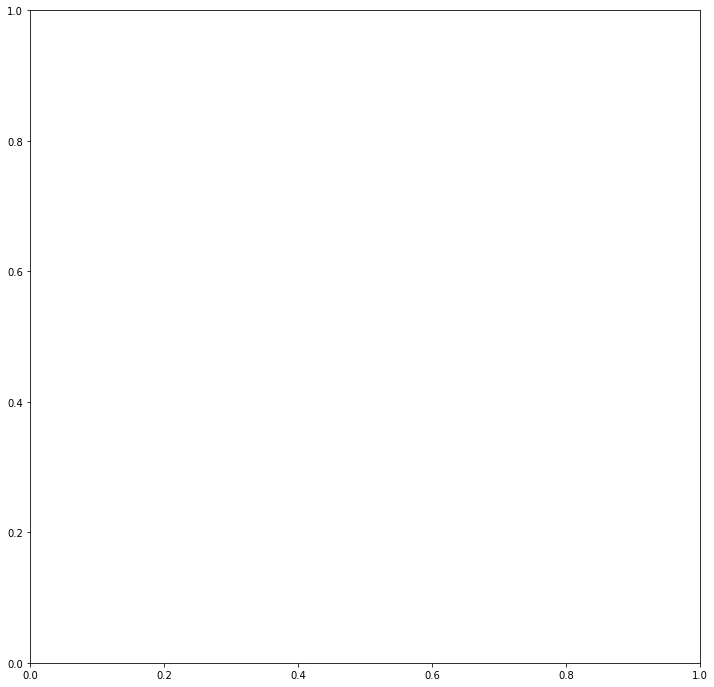

In [35]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
 
# Load the image (http://python-graph-gallery.com/wp-content/uploads/wave.jpg)
us_mask = np.array(Image.open( "US3.png"))
 
# Make the figure
wordcloud = WordCloud(background_color="white", colormap="Greens",relative_scaling=1,prefer_horizontal=0.9).generate_from_frequencies(dict(rdd_positive_words_cnt.take(20)))
#plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.margins(x=0, y=0)
plt.title('positive wordcloud',fontsize=20, fontweight= 'bold',va='center' )
plt.show()

**<font color= green> The positive words are quite general and do not seem to focus on specific topics</font>**

**<font color= green>the most negative words</font>**

In [ ]:
negative_words_list = sc.textFile('negative-words.txt').collect()
rdd_negative_words_cnt = rdd_words_cnt.filter(lambda x : x[0] in negative_words_list)
print("the most used negative words are")
rdd_negative_words_cnt.take(20)

NameError: name 'WordCloud' is not defined

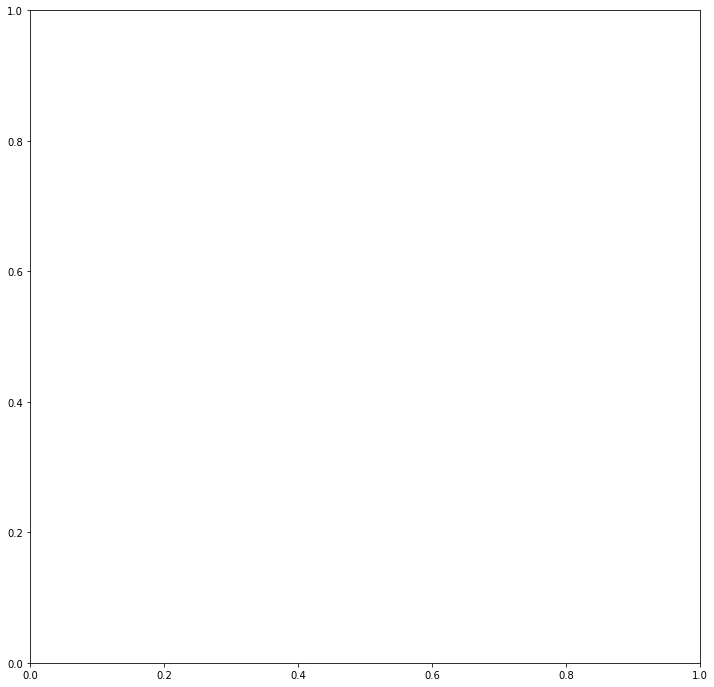

In [36]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
 
# Load the image (http://python-graph-gallery.com/wp-content/uploads/wave.jpg)
us_mask = np.array(Image.open( "US3.png"))
 
# Make the figure
wordcloud = WordCloud(background_color="white", colormap="Reds",relative_scaling=1,prefer_horizontal=0.9).generate_from_frequencies(dict(rdd_negative_words_cnt.take(20)))
#plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.margins(x=0, y=0)
plt.title('negative wordcloud',fontsize=20, fontweight= 'bold',va='center' )
plt.show()

**<font color= green> The negative narrative is largely for US national topis e.g. against media or impeachment</font>**

# language detection

here we want to detect the different languages used in the tweets

In [37]:
DetectorFactory.seed = 0
def detect_lang(str):
    try:
        return detect_langs(str)
    except:
        return detect_langs(" this is a dummy sentence to fake in case function is failing")

# remove hastags, @ and any messages below 30 characters
rdd_lang_prob = rdd_tweets_clean.map(lambda x : re.sub(r"#\S+", "", x))\
                           .map(lambda x : re.sub(r"@\S+", "", x))\
                           .filter(lambda x : len(x) > 30)\
                           .map(detect_lang)

NameError: name 'DetectorFactory' is not defined

In [38]:
# keep only languages detected with over 90% likelihood, count by language
rdd_lang = rdd_lang_prob.map(lambda x : x[0])\
                        .filter(lambda x : x.prob > 0.9)\
                        .map(lambda x : x.lang)\
                        .map(lambda x : (x,1))\
                        .reduceByKey(lambda a,b: a+b)


NameError: name 'rdd_lang_prob' is not defined

In [39]:
# put list of languages used in a list
lang_used_list = rdd_lang.collect()

NameError: name 'rdd_lang' is not defined

In [40]:
# read the language corresponding to each code
lang_code = pd.read_csv('language_code.csv')

# put it in  a dictionary
lang_dict = dict(lang_code.to_dict(orient='split')['data'])

In [41]:
# find and display the languages used
print(" Here is the list of languages used in tweets")
for tup in lang_used_list:
    lang       = tup[0]
    lang_count = tup[1]
    try:
        print("    - ", lang_count, " tweets in ", lang_dict[lang])
    except:
        print("    - ", lang_count, " tweets in unknown language(", lang,")")


 Here is the list of languages used in tweets


NameError: name 'lang_used_list' is not defined

**<font color= green>Obviously the vast majority of tweets are written in english <br>
But it's still interesting to see that others languages are used <br>
It is either to address a large US community like spanish like latinos, pass a message to some populations e.g. persan for iranians or visiting a country
It is also to be noted that language is not perfect, it could be improved by doing further text processing</font>**

